/tmp/ipykernel_68964/1237269302.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre"], inplace=True)


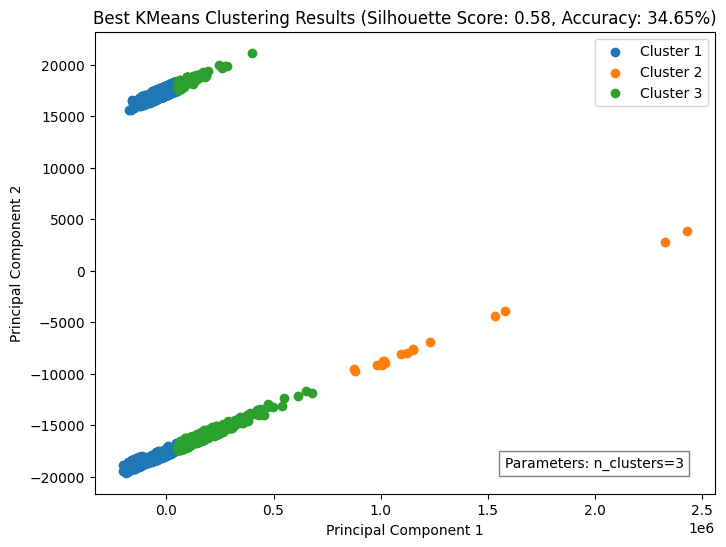

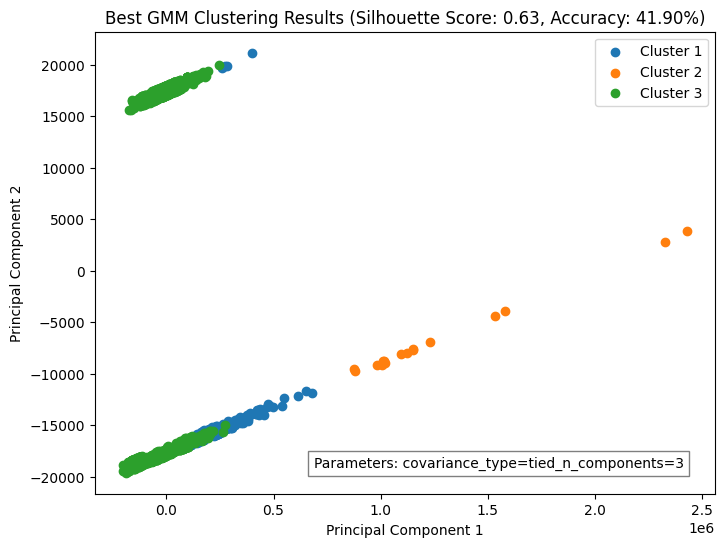

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


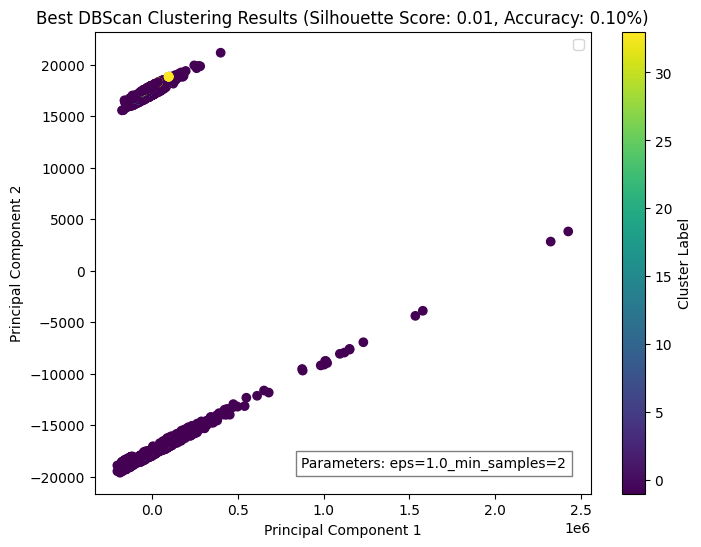

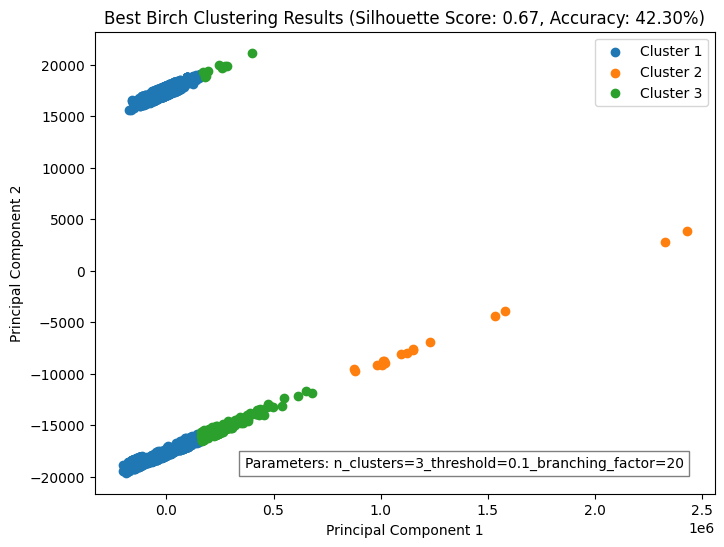

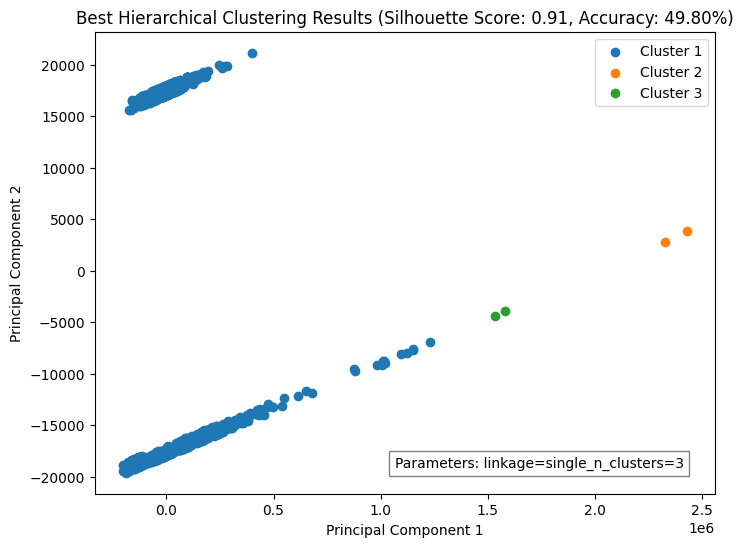

Overall best clustering method: Hierarchical with parameters linkage=single_n_clusters=3
Overall best silhouette score: 0.9068518562945611
Overall Best Clustering Result:
+----+--------------+-----------------------------+--------------------+------------+---------------------------------------------------------+
|    | Method       | Parameters                  |   Silhouette Score |   Accuracy | Model                                                   |
|----+--------------+-----------------------------+--------------------+------------+---------------------------------------------------------|
|  0 | Hierarchical | linkage=single_n_clusters=3 |           0.906852 |      0.498 | AgglomerativeClustering(linkage='single', n_clusters=3) |
+----+--------------+-----------------------------+--------------------+------------+---------------------------------------------------------+


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score
from tabulate import tabulate
import numpy as np

data = pd.read_csv("dataset.csv")
accuracy_run=50
chosen_genres = ["hip-hop", "Rock", "classical"]
filtered_data = data[data['track_genre'].isin(chosen_genres)]

# Drop problematic columns
filtered_data.drop(columns=["track_id", "artists", "album_name", "track_name", "track_genre"], inplace=True)

# Preprocessing
scaler = StandardScaler()
scaled_data = filtered_data
scaled_data2 = scaler.fit_transform(filtered_data)

# Calculate PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

best_cluster_results = []

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
accuracy = accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels)
best_cluster_results.append(("KMeans", "n_clusters=3", silhouette_avg, accuracy, kmeans))

# Hierarchical
linkage_methods = ['ward', 'complete', 'average', 'single']
for linkage_method in linkage_methods:
    hier_clustering = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
    cluster_labels = hier_clustering.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    davies_bouldin_index = davies_bouldin_score(scaled_data, cluster_labels)
    accuracy_scores = []
    for x in range(1,accuracy_run):
       accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
    accuracy=np.mean(accuracy_scores)
    best_cluster_results.append(("Hierarchical", f"linkage={linkage_method}_n_clusters=3", silhouette_avg, accuracy, hier_clustering))

# DBScan
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [2, 5, 10]
for eps_val in eps_values:
    for min_samples_val in min_samples_values:
        dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        cluster_labels = dbscan.fit_predict(scaled_data2)
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(scaled_data2, cluster_labels)
            accuracy_scores = []
            for x in range(1,accuracy_run):
                 accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
            accuracy=np.mean(accuracy_scores)
            best_cluster_results.append(("DBScan", f"eps={eps_val}_min_samples={min_samples_val}", silhouette_avg, accuracy, dbscan))

# Birch
thresholds = [0.1, 0.5, 1.0]
branching_factors = [20, 50, 100]
for threshold_val in thresholds:
    for branching_factor_val in branching_factors:
        birch = Birch(n_clusters=3, threshold=threshold_val, branching_factor=branching_factor_val)
        cluster_labels = birch.fit_predict(scaled_data)
        silhouette_avg = silhouette_score(scaled_data, cluster_labels)
        accuracy_scores = []
        for x in range(1,accuracy_run):
            accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
        accuracy=np.mean(accuracy_scores)
        best_cluster_results.append(("Birch", f"n_clusters=3_threshold={threshold_val}_branching_factor={branching_factor_val}", silhouette_avg, accuracy, birch))

# GMM
covariance_types = ['full', 'tied', 'diag', 'spherical']
for covariance_type_val in covariance_types:
    gmm = GaussianMixture(n_components=3, covariance_type=covariance_type_val)
    gmm.fit(scaled_data)
    cluster_labels = gmm.predict(scaled_data)

    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    accuracy_scores = []
    for x in range(1,accuracy_run):
        accuracy_scores.append(accuracy_score(data[data['track_genre'].isin(chosen_genres)].groupby('track_genre').ngroup(), cluster_labels))
    accuracy=np.mean(accuracy_scores)
    best_cluster_results.append(("GMM", f"covariance_type={covariance_type_val}_n_components=3", silhouette_avg, accuracy, gmm))

for method in set(result[0] for result in best_cluster_results):
    best_result = max((result for result in best_cluster_results if result[0] == method), key=lambda x: x[2])
    best_model = best_result[4]  # model is now at index 4 in the tuple
    cluster_labels = best_model.fit_predict(scaled_data)

    plt.figure(figsize=(8, 6))
    if isinstance(best_model, KMeans):
        for i in range(best_model.n_clusters):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, AgglomerativeClustering):
        for i in range(best_model.n_clusters):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, DBSCAN):
        plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
        plt.colorbar(label='Cluster Label')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, Birch):
        for i in range(len(set(cluster_labels))):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')
    elif isinstance(best_model, GaussianMixture):
        for i in range(best_model.n_components):
            plt.scatter(pca_data[cluster_labels == i, 0], pca_data[cluster_labels == i, 1], label=f'Cluster {i+1}')
        plt.title(f'Best {method} Clustering Results (Silhouette Score: {best_result[2]:.2f}, Accuracy: {best_result[3]*100:.2f}%)')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    # Adding model parameters to the plot
    plt.text(0.95, 0.05, f'Parameters: {best_result[1]}', ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

overall_best_result = max(best_cluster_results, key=lambda x: x[2])

print(f"Overall best clustering method: {overall_best_result[0]} with parameters {overall_best_result[1]}")
print(f"Overall best silhouette score: {overall_best_result[2]}")

columns = ['Method', 'Parameters', 'Silhouette Score', 'Accuracy', 'Model']
overall_best_result_df = pd.DataFrame([overall_best_result], columns=columns)

print("Overall Best Clustering Result:")
print(tabulate(overall_best_result_df, headers='keys', tablefmt='psql'))
